<a href="https://colab.research.google.com/github/etemadism/Courses/blob/main/04_ANOVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Decision Flowchart**

Determine the Number of Factors:

*   One Factor → **One-Way ANOVA**.
*   Two Factors → **Two-Way ANOVA**.

*   Repeated Measures → **Repeated Measures ANOVA**.


Check Assumptions:

* **Normality**: Use **Shapiro-Wilk** or **Kolmogorov-Smirnov** tests.

* **Homogeneity of Variance**: Use **Levene’s** Test.

**If Assumptions Are Met**:


* Use the appropriate parametric test (One-Way ANOVA, Two-Way ANOVA, etc.).


**If Assumptions Are Violated**:

* **Non-Normality**:

* **One-Way**: Kruskal-Wallis.

* **Two-Way**: ART ANOVA or Permutation ANOVA.

* **Repeated Measures**: Friedman Test.


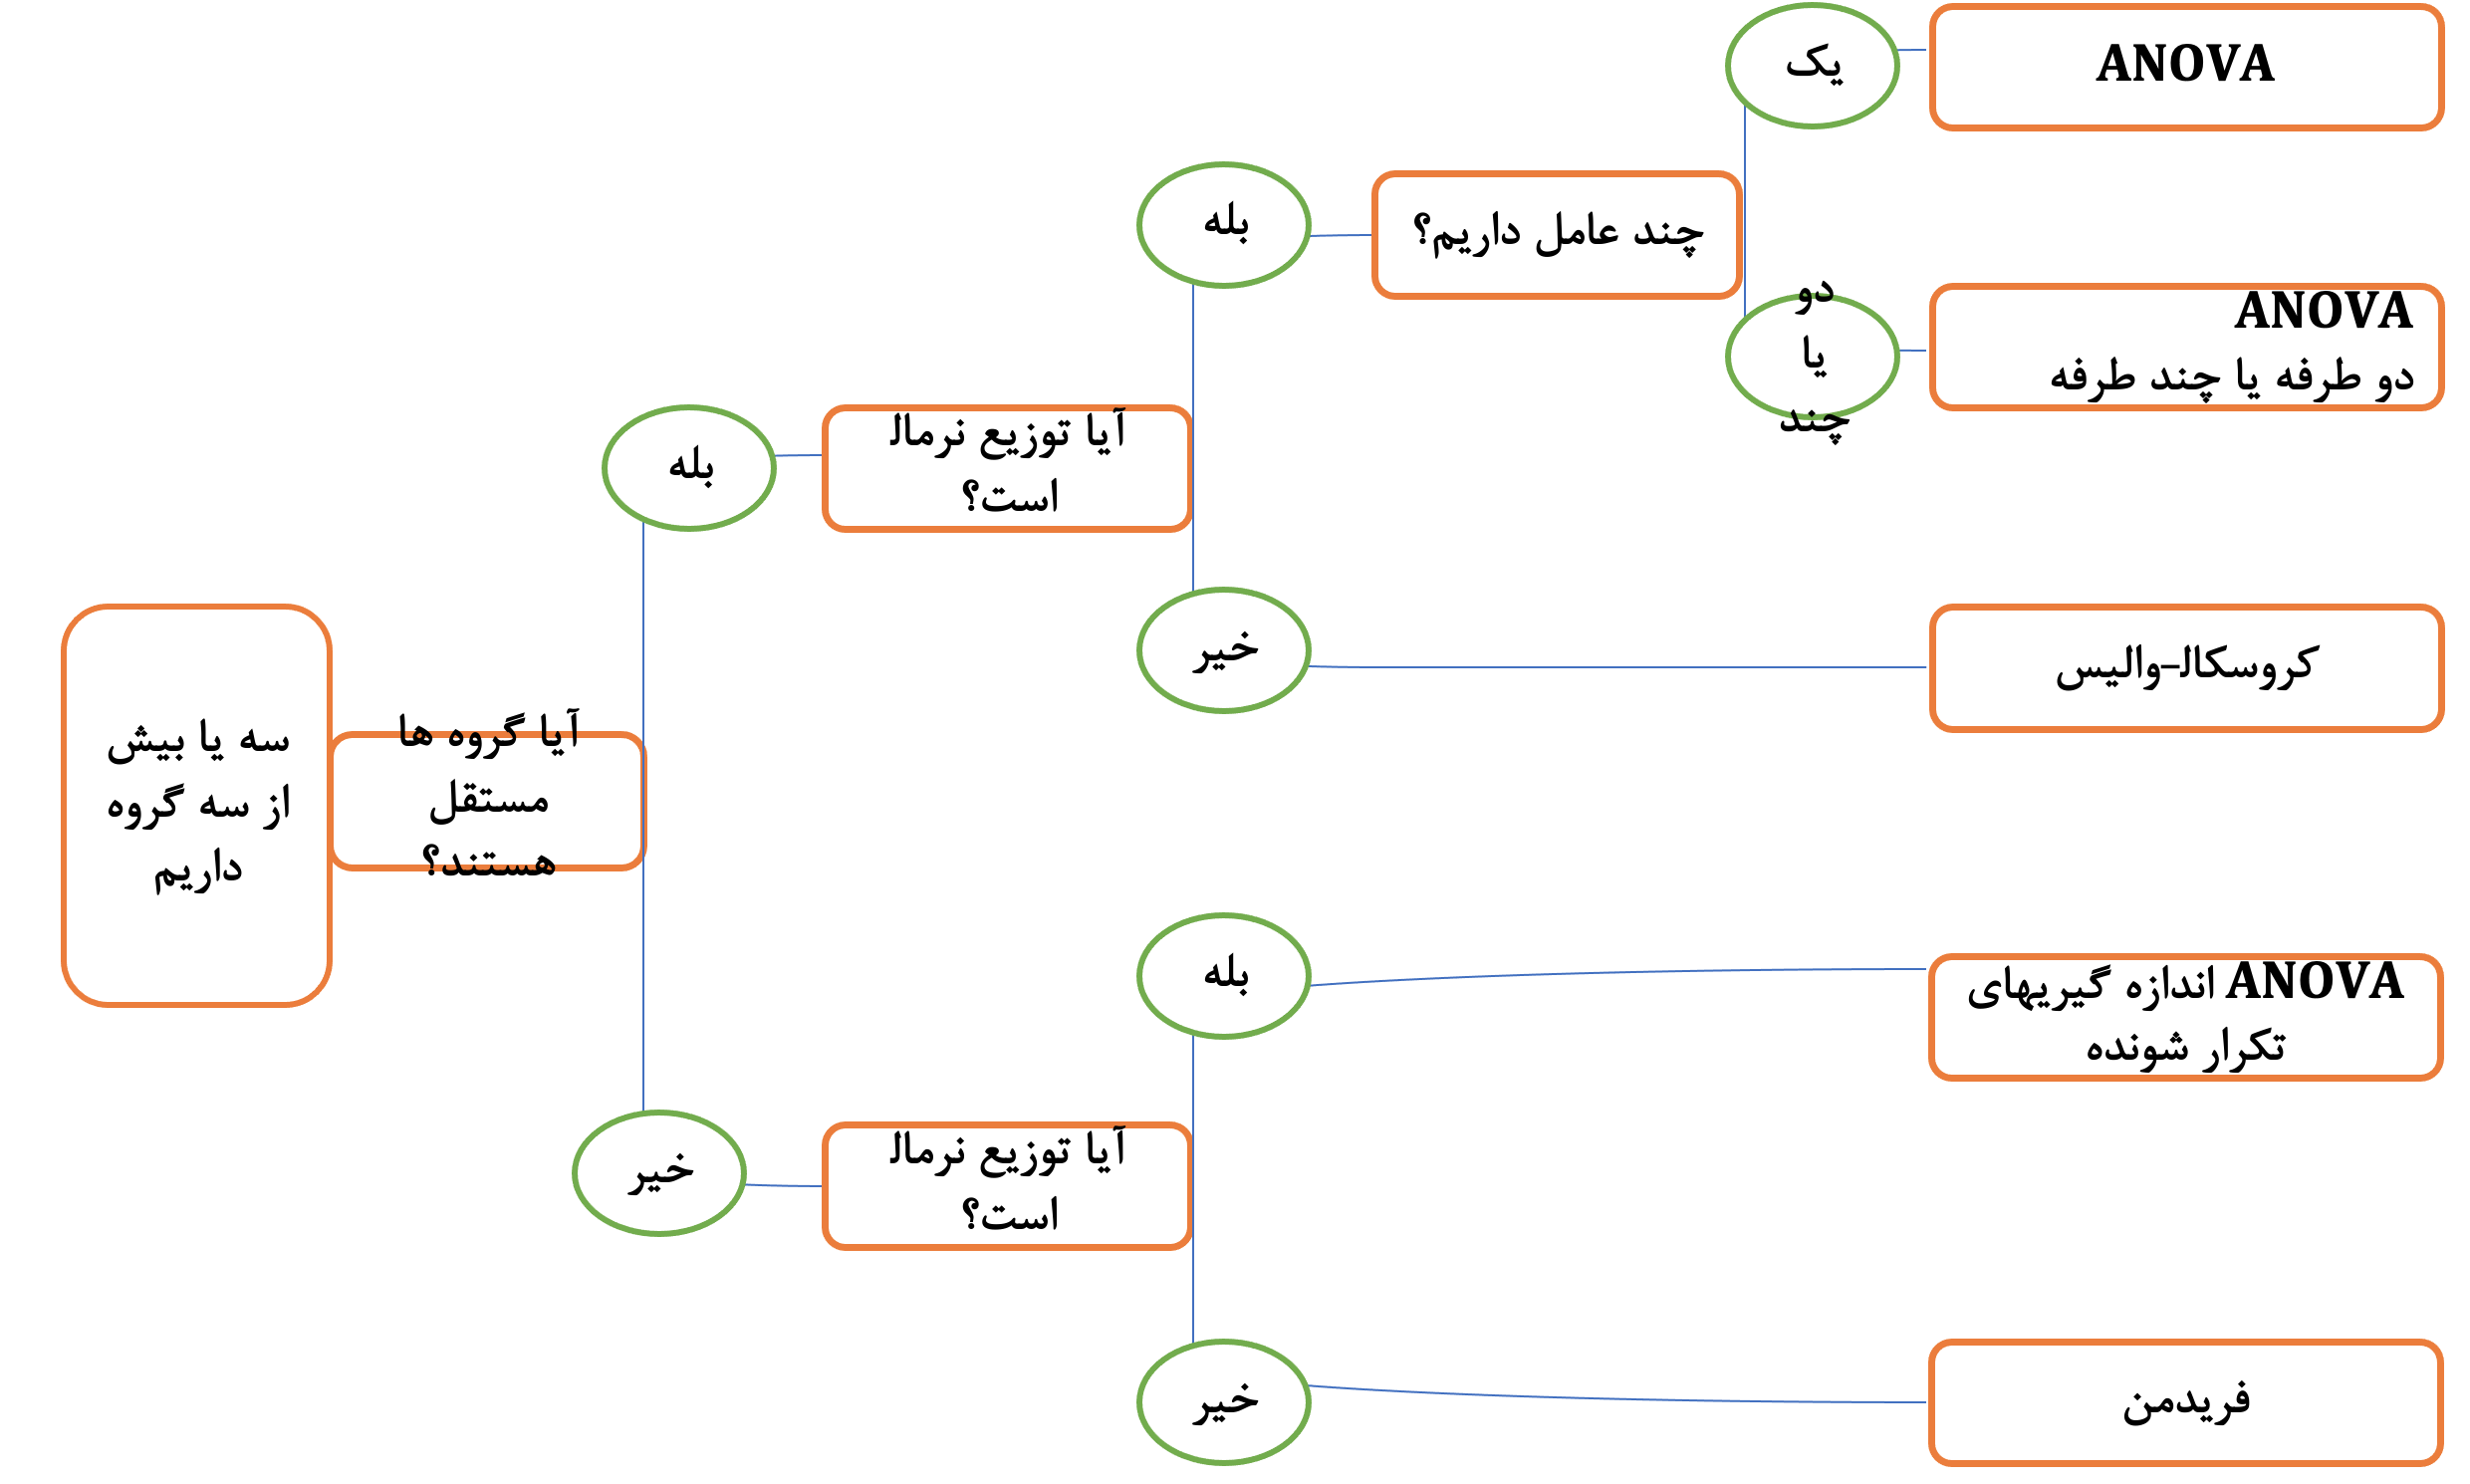

#ANOVA (Multiple Independent Groups)

## One-way ANOVA

We are analyzing the expression levels of GeneA under three different environmental conditions:
* Control (C),
* Stress (S),
* and Drug Treatment (D).

The study investigates whether the environmental condition affects the expression levels of GeneA, which plays a crucial role in cellular stress response and drug metabolism.

###Importing required libraries


In [36]:
import numpy as np
import pandas as pd
from scipy.stats import shapiro, kstest, levene, f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM


###Data

In [37]:
df = pd.read_csv("One_way_anova_Independent_sample.csv")
df

,Condition,GeneA_Expression
0,Control,10.2
1,Control,10.5
2,Control,9.8
3,Control,11.0
4,Control,10.3
5,Control,10.7
6,Stress,18.2
7,Stress,19.5
8,Stress,17.8
9,Stress,18.3


In [38]:
group1= df[df['Condition'] == 'Control']['GeneA_Expression']
group2= df[df['Condition'] == 'Stress']['GeneA_Expression']
group3= df[df['Condition'] == 'Drug']['GeneA_Expression']

### Step 1: Normality test




In [39]:
# Function to select normality test based on sample size
def normality_test(data, threshold=50):
    """Perform Shapiro-Wilk if n < threshold, otherwise Kolmogorov-Smirnov."""
    n = len(data)
    if n < threshold:
        stat, p_value = shapiro(data)
        test = "Shapiro-Wilk"
    else:
        stat, p_value = kstest(data, 'norm')
        test = "Kolmogorov-Smirnov"
    return test, stat, p_value

In [40]:
# Step 1: Normality Check
print("\n--- Normality Check ---")
for group in df['Condition'].unique():
    group_data = df[df['Condition'] == group]['GeneA_Expression']
    test, stat, p_value = normality_test(group_data)
    print(f"{group} ({test}): Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"{group}: Data is normally distributed (fail to reject H0).")
    else:
        print(f"{group}: Data is not normally distributed (reject H0).")


--- Normality Check ---
Control (Shapiro-Wilk): Statistic=0.9951, p-value=0.9980
Control: Data is normally distributed (fail to reject H0).
Stress (Shapiro-Wilk): Statistic=0.9797, p-value=0.9500
Stress: Data is normally distributed (fail to reject H0).
Drug (Shapiro-Wilk): Statistic=0.9510, p-value=0.7481
Drug: Data is normally distributed (fail to reject H0).


### Step 2: Homogeneity of Variances Check

In [41]:
print("\n--- Homogeneity of Variances (Levene’s Test) ---")
stat, p_value = levene(group1, group2, group3)
print(f"Levene Statistic={stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("Homogeneity of variances assumption is met (fail to reject H0).")
else:
    print("Homogeneity of variances assumption is not met (reject H0).")



--- Homogeneity of Variances (Levene’s Test) ---
Levene Statistic=1.1171, p-value=0.3530
Homogeneity of variances assumption is met (fail to reject H0).


### Step 3: One-Way ANOVA (Pooled or Welch’s)


In [42]:
# Import necessary libraries
import pandas as pd
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests
from pingouin import welch_anova, pairwise_gameshowell

# Perform One-Way ANOVA or Welch's ANOVA
print("\n--- One-Way ANOVA ---")
if p_value > 0.05:
    # Perform pooled ANOVA
    print("Performing Pooled ANOVA (homogeneous variances).")
    stat, p_value = f_oneway(group1, group2, group3)
else:
    # Perform Welch's ANOVA
    print("Performing Welch’s ANOVA (unequal variances).")
    #df_anova = pd.DataFrame({'Score': GeneA_Expression, 'Group': conditions})
    df_anova = df.rename(columns={'GeneA_Expression': 'Score', 'Condition': 'Group'})
    welch_result = welch_anova(dv='Score', between='Group', data=df_anova)
    stat, p_value = welch_result['F'].iloc[0], welch_result['p-unc'].iloc[0]

print(f"F-Statistic={stat:.4f}, p-value={p_value:.4f}")
if p_value > 0.05:
    print("No significant difference between group means (fail to reject H0).")
else:
    print("Significant difference between group means (reject H0).")



--- One-Way ANOVA ---
Performing Pooled ANOVA (homogeneous variances).
F-Statistic=449.5375, p-value=0.0000
Significant difference between group means (reject H0).


### Step 4: Post-hoc Analysis

In [43]:
# Step 4: Post-hoc Analysis
if p_value <= 0.05:
    print("\n--- Post-hoc Analysis ---")

    if p_value > 0.05:
        # Tukey's HSD if variances are equal
        print("--- Tukey’s HSD ---")
        tukey = pairwise_tukeyhsd(endog=df['Score'], groups=df['Group'], alpha=0.05)
        print(tukey)

        # Bonferroni Correction
        print("\n--- Bonferroni Correction ---")
        p_values = []
        comparisons = []
        group_names = df['Group'].unique()

        for i in range(len(group_names)):
            for j in range(i + 1, len(group_names)):
                stat, p = ttest_ind(
                    df[df['Group'] == group_names[i]]['Score'],
                    df[df['Group'] == group_names[j]]['Score']
                )
                p_values.append(p)
                comparisons.append(f"{group_names[i]} vs {group_names[j]}")

        # Apply Bonferroni correction
        adjusted_p_values = multipletests(p_values, alpha=0.05, method='bonferroni')[1]

        for comp, p, adj_p in zip(comparisons, p_values, adjusted_p_values):
            print(f"{comp}: Raw p-value={p:.4f}, Adjusted p-value={adj_p:.4f}")
            if adj_p > 0.05:
                print(f"{comp}: No significant difference (fail to reject H0).")
            else:
                print(f"{comp}: Significant difference (reject H0).")
    else:
        # Print Games-Howell Test Results
        print("\n--- Games-Howell Test ---")
        games_howell = pairwise_gameshowell(dv='Score', between='Group', data=df_anova)

        # Loop through the results and display comparisons
        for i, row in games_howell.iterrows():
            print(f"Comparison: {row['A']} vs {row['B']}")
            print(f"Mean Difference: {row['diff']:.4f}")
            print(f"Standard Error: {row['se']:.4f}")
            print(f"T-Statistic: {row['T']:.4f}")
            print(f"Degrees of Freedom: {row['df']:.4f}")
            print(f"p-value: {row['pval']:.4f}")
            print(f"Hedges' g: {row['hedges']:.4f}")
            if row['pval'] <= 0.05:
                print("Significant difference (reject H0).")
            else:
                print("No significant difference (fail to reject H0).")
            print("-" * 40)



--- Post-hoc Analysis ---

--- Games-Howell Test ---
Comparison: Control vs Drug
Mean Difference: -4.5333
Standard Error: 0.2224
T-Statistic: -20.3873
Degrees of Freedom: 9.7166
p-value: 0.0000
Hedges' g: -10.8652
Significant difference (reject H0).
----------------------------------------
Comparison: Control vs Stress
Mean Difference: -8.1667
Standard Error: 0.3020
T-Statistic: -27.0392
Degrees of Freedom: 8.8221
p-value: 0.0000
Hedges' g: -14.4103
Significant difference (reject H0).
----------------------------------------
Comparison: Drug vs Stress
Mean Difference: -3.6333
Standard Error: 0.2877
T-Statistic: -12.6284
Degrees of Freedom: 7.9699
p-value: 0.0000
Hedges' g: -6.7302
Significant difference (reject H0).
----------------------------------------


## Two-way ANOVA

Here we have a sample dataset for a two-way ANOVA analysis investigating the effects of two factors (e.g., Treatment and Time) on Protein Concentration.

**Dataset Description**

**Factor 1 (Treatment)**: Includes Control, DrugA, and DrugB.

**Factor 2 (Time)**: Includes Day1, Day2, and Day3.

**Dependent Variable (Protein Concentration)**: Measured in arbitrary units.

In [44]:
import pandas as pd
from scipy.stats import levene
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import welch_anova, pairwise_gameshowell, pairwise_tests

# Example Data: Two factors - 'Treatment' and 'Time', dependent variable - 'Score'
data = pd.read_csv("/content/Two_way_anova_independent_sample_data.csv")
data

,Treatment,Time,Protein_Concentration
0,Control,Day1,12.1
1,Control,Day2,13.5
2,Control,Day3,14.2
3,Control,Day1,11.8
4,Control,Day2,12.9
5,Control,Day3,13.6
6,DrugA,Day1,18.4
7,DrugA,Day2,20.1
8,DrugA,Day3,21.3
9,DrugA,Day1,17.9


In [45]:
from scipy.stats import levene

# Function to check homogeneity of variances
def check_variance_homogeneity(data, factor, dependent_variable):
    """
    Performs Levene's test to check the homogeneity of variances for the given factor.

    Parameters:
        data (DataFrame): The dataset containing the factors and dependent variable.
        factor (str): The column name of the factor (e.g., 'Treatment', 'Time').
        dependent_variable (str): The column name of the dependent variable (e.g., 'Protein_Concentration').

    Returns:
        bool: True if variances are homogeneous, False otherwise.
    """
    # Split data into groups based on the levels of the factor
    groups = [data[data[factor] == level][dependent_variable] for level in data[factor].unique()]

    # Perform Levene's test
    test = levene(*groups)
    print(f"Levene's Test for {factor}: p={test.pvalue:.4f}")

    # Return True if p-value > 0.05 (homogeneity assumed)
    return test.pvalue > 0.05


# Check homogeneity of variances for Treatment and Time
print("\n--- Homogeneity of Variances ---")
treatment_homogeneous = check_variance_homogeneity(data, 'Treatment', 'Protein_Concentration')
time_homogeneous = check_variance_homogeneity(data, 'Time', 'Protein_Concentration')

# Display results
print(f"Treatment Homogeneous Variances: {treatment_homogeneous}")
print(f"Time Homogeneous Variances: {time_homogeneous}")




--- Homogeneity of Variances ---
Levene's Test for Treatment: p=0.7762
Levene's Test for Time: p=0.9095
Treatment Homogeneous Variances: True
Time Homogeneous Variances: True


In [46]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from pingouin import pairwise_gameshowell, pairwise_tests, welch_anova

# Function to perform and print post-hoc tests
def perform_posthoc(data, dependent_var, factor, method='bonf'):
    print(f"\n--- Post-hoc Test for {factor} ({method.capitalize()}) ---")
    posthoc_results = pairwise_tests(dv=dependent_var, between=factor, data=data, padjust=method)
    print(posthoc_results)

# Two-Way ANOVA if variances are homogeneous
if treatment_homogeneous and time_homogeneous:
    print("\n--- Pooled Two-Way ANOVA (homogeneous variances) ---")
    model = ols('Protein_Concentration ~ C(Treatment) + C(Time) + C(Treatment):C(Time)', data=data).fit()
    anova_results = anova_lm(model)
    print(anova_results)

    # Post-hoc tests for significant results
    if anova_results["PR(>F)"][0] <= 0.05:
        perform_posthoc(data, 'Protein_Concentration', 'Treatment', method='bonf')
    if anova_results["PR(>F)"][1] <= 0.05:
        perform_posthoc(data, 'Protein_Concentration', 'Time', method='bonf')
    if anova_results["PR(>F)"][2] <= 0.05:
        print("\n--- Interaction Effects Detected. Post-hoc not supported for interaction terms directly. ---")

# Welch ANOVA if variances are unequal
else:
    print("\n--- Variances are unequal. Performing Welch ANOVA ---")
    for factor in ['Treatment', 'Time']:
        welch_results = welch_anova(dv='Protein_Concentration', between=factor, data=data)
        print(f"\n--- Welch ANOVA for {factor} ---")
        print(welch_results)

        if welch_results['p-unc'].iloc[0] <= 0.05:
            print(f"\n--- Post-hoc Test for {factor} (Games-Howell) ---")
            posthoc_results = pairwise_gameshowell(dv='Protein_Concentration', between=factor, data=data)
            print(posthoc_results)



--- Pooled Two-Way ANOVA (homogeneous variances) ---
                       df      sum_sq    mean_sq           F        PR(>F)
C(Treatment)          2.0  136.201111  68.100556  305.688279  5.335094e-09
C(Time)               2.0   16.107778   8.053889   36.152120  4.995534e-05
C(Treatment):C(Time)  4.0    0.495556   0.123889    0.556110  7.002064e-01
Residual              9.0    2.005000   0.222778         NaN           NaN

--- Post-hoc Test for Treatment (Bonf) ---
    Contrast        A      B  Paired  Parametric          T   dof alternative  \
0  Treatment  Control  DrugA   False        True -10.165100  10.0   two-sided   
1  Treatment  Control  DrugB   False        True  -7.090883  10.0   two-sided   
2  Treatment    DrugA  DrugB   False        True   3.765875  10.0   two-sided   

      p-unc    p-corr p-adjust      BF10    hedges  
0  0.000001  0.000004     bonf  6751.382 -5.417375  
1  0.000033  0.000100     bonf   439.696 -3.779006  
2  0.003686  0.011059     bonf    10.604  2

<ipython-input-46-6441bae5bd84>:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results["PR(>F)"][0] <= 0.05:
<ipython-input-46-6441bae5bd84>:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results["PR(>F)"][1] <= 0.05:
<ipython-input-46-6441bae5bd84>:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if anova_results["PR(>F)"][2] <= 0.05:


# Repeated Measures ANOVA (Multiple Related Groups)

## One-way Repeated Measures ANOVA

### Import data

In [48]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM



# Convert to long format
df = pd.read_csv("/content/One_Way_Repeated_Measures_ANOVA_sample_data.csv")


df

,Subject,Drug_Concentration,Protein_Expression
0,1,0 (Control),15.2
1,1,10 µM,18.4
2,1,50 µM,22.1
3,2,0 (Control),14.8
4,2,10 µM,17.3
5,2,50 µM,21.6
6,3,0 (Control),16.0
7,3,10 µM,19.2
8,3,50 µM,23.0
9,4,0 (Control),15.5


### Step 1: Normality test




In [ ]:
# Function to select normality test based on sample size
def normality_test(data, threshold=50):
    """Perform Shapiro-Wilk if n < threshold, otherwise Kolmogorov-Smirnov."""
    n = len(data)
    if n < threshold:
        stat, p_value = shapiro(data)
        test = "Shapiro-Wilk"
    else:
        stat, p_value = kstest(data, 'norm')
        test = "Kolmogorov-Smirnov"
    return test, stat, p_value

In [ ]:
# Step 1: Normality Check
print("\n--- Normality Check ---")
for group in df['Drug_Concentration'].unique():
    group_data = df[df['Drug_Concentration'] == group]['Protein_Expression']
    test, stat, p_value = normality_test(group_data)
    print(f"{group} ({test}): Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"{group}: Data is normally distributed (fail to reject H0).")
    else:
        print(f"{group}: Data is not normally distributed (reject H0).")


--- Normality Check ---
0 (Control) (Shapiro-Wilk): Statistic=0.9582, p-value=0.7951
0 (Control): Data is normally distributed (fail to reject H0).
10 µM (Shapiro-Wilk): Statistic=0.9848, p-value=0.9586
10 µM: Data is normally distributed (fail to reject H0).
50 µM (Shapiro-Wilk): Statistic=0.9695, p-value=0.8720
50 µM: Data is normally distributed (fail to reject H0).


### Step 2: Perform One-Way Repeated Measures ANOVA


In [52]:
# Perform One-Way Repeated Measures ANOVA
aovrm = AnovaRM(data=df, depvar='Protein_Expression', subject='Subject', within=['Drug_Concentration'])
results = aovrm.fit()
print(results)

                      Anova
                    F Value  Num DF Den DF Pr > F
-------------------------------------------------
Drug_Concentration 2227.8519 2.0000 8.0000 0.0000



### Step 3: Post-hoc Analysis

In [53]:
import pandas as pd
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests

# --- Bonferroni-Adjusted Pairwise T-Tests ---
concentrations = df['Drug_Concentration'].unique()
p_values = []
comparisons = []

# Pairwise t-tests
for i in range(len(concentrations)):
    for j in range(i + 1, len(concentrations)):
        group1 = df[df['Drug_Concentration'] == concentrations[i]]['Protein_Expression']
        group2 = df[df['Drug_Concentration'] == concentrations[j]]['Protein_Expression']
        stat, p = ttest_rel(group1, group2)
        p_values.append(p)
        comparisons.append(f"{concentrations[i]} vs {concentrations[j]}")

# Adjust p-values for multiple comparisons
adjusted_p_values = multipletests(p_values, method='bonferroni')[1]

# Print Bonferroni results
print("\n--- Bonferroni-Adjusted Pairwise Comparisons ---")
for comp, p, adj_p in zip(comparisons, p_values, adjusted_p_values):
    print(f"{comp}: Raw p-value = {p:.4f}, Adjusted p-value = {adj_p:.4f}")
    if adj_p <= 0.05:
        print(f"{comp}: Significant difference (reject H0).")
    else:
        print(f"{comp}: No significant difference (fail to reject H0).")

# --- Tukey's HSD ---
# Flatten the data for Tukey's HSD
df_long = df[['Drug_Concentration', 'Protein_Expression']]

# Perform Tukey's HSD
tukey = pairwise_tukeyhsd(
    endog=df_long['Protein_Expression'],
    groups=df_long['Drug_Concentration'],
    alpha=0.05,
)

print("\n--- Tukey's HSD Results ---")
print(tukey)



--- Bonferroni-Adjusted Pairwise Comparisons ---
0 (Control) vs 10 µM: Raw p-value = 0.0000, Adjusted p-value = 0.0001
0 (Control) vs 10 µM: Significant difference (reject H0).
0 (Control) vs 50 µM: Raw p-value = 0.0000, Adjusted p-value = 0.0000
0 (Control) vs 50 µM: Significant difference (reject H0).
10 µM vs 50 µM: Raw p-value = 0.0000, Adjusted p-value = 0.0000
10 µM vs 50 µM: Significant difference (reject H0).

--- Tukey's HSD Results ---
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
   group1   group2 meandiff p-adj lower  upper  reject
------------------------------------------------------
0 (Control)  10 µM     3.04   0.0 2.0683 4.0117   True
0 (Control)  50 µM     6.92   0.0 5.9483 7.8917   True
      10 µM  50 µM     3.88   0.0 2.9083 4.8517   True
------------------------------------------------------


## Two-way Repeated Measures ANOVA

### Import data

In [63]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM


df = pd.read_csv("Two-Way_Repeated_Measures_ANOVA_sample_data.csv")

df


,Subject,Drug_Concentration,Time_Point,Protein_Expression
0,1,Low,Day 1,12.1
1,1,Low,Day 7,12.5
2,1,Low,Day 14,13.0
3,1,Medium,Day 1,14.2
4,1,Medium,Day 7,14.7
5,1,Medium,Day 14,15.2
6,1,High,Day 1,16.8
7,1,High,Day 7,17.3
8,1,High,Day 14,17.7
9,2,Low,Day 1,11.8


### Step 1: Normality test




In [64]:
# Function to select normality test based on sample size
def normality_test(data, threshold=50):
    """Perform Shapiro-Wilk if n < threshold, otherwise Kolmogorov-Smirnov."""
    n = len(data)
    if n < threshold:
        stat, p_value = shapiro(data)
        test = "Shapiro-Wilk"
    else:
        stat, p_value = kstest(data, 'norm')
        test = "Kolmogorov-Smirnov"
    return test, stat, p_value

In [65]:
# Step 1: Normality Check
print("\n--- Normality Check ---")
for group in df['Drug_Concentration'].unique():
    group_data = df[df['Drug_Concentration'] == group]['Protein_Expression']
    test, stat, p_value = normality_test(group_data)
    print(f"{group} ({test}): Statistic={stat:.4f}, p-value={p_value:.4f}")
    if p_value > 0.05:
        print(f"{group}: Data is normally distributed (fail to reject H0).")
    else:
        print(f"{group}: Data is not normally distributed (reject H0).")


--- Normality Check ---
Low (Shapiro-Wilk): Statistic=0.9608, p-value=0.7057
Low: Data is normally distributed (fail to reject H0).
Medium (Shapiro-Wilk): Statistic=0.9636, p-value=0.7545
Medium: Data is normally distributed (fail to reject H0).
High (Shapiro-Wilk): Statistic=0.9528, p-value=0.5693
High: Data is normally distributed (fail to reject H0).


### Step 2: Two-Way Repeated Measures ANOVA

In [71]:
import pandas as pd
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_rel
from statsmodels.stats.multitest import multipletests


# --- Two-Way Repeated Measures ANOVA ---
aovrm = AnovaRM(data=df, depvar='Protein_Expression', subject='Subject', within=['Drug_Concentration', 'Time_Point'])
results = aovrm.fit()
print("\n--- Two-Way Repeated Measures ANOVA Results ---")
print(results)


--- Two-Way Repeated Measures ANOVA Results ---
                            Anova
                               F Value  Num DF  Den DF Pr > F
-------------------------------------------------------------
Drug_Concentration            6968.6852 2.0000  8.0000 0.0000
Time_Point                     547.4035 2.0000  8.0000 0.0000
Drug_Concentration:Time_Point    2.9919 4.0000 16.0000 0.0508



### Step 3: Post-hoc Analysis

In [70]:
# --- Bonferroni-Adjusted Pairwise T-Tests ---
# Post-hoc for Drug_Concentration
drug_levels = df['Drug_Concentration'].unique()
p_values_drug = []
comparisons_drug = []

for i in range(len(drug_levels)):
    for j in range(i + 1, len(drug_levels)):
        group1 = df[df['Drug_Concentration'] == drug_levels[i]]['Protein_Expression']
        group2 = df[df['Drug_Concentration'] == drug_levels[j]]['Protein_Expression']
        stat, p = ttest_rel(group1, group2)
        p_values_drug.append(p)
        comparisons_drug.append(f"{drug_levels[i]} vs {drug_levels[j]}")

# Adjust p-values for Drug_Concentration
adjusted_p_values_drug = multipletests(p_values_drug, method='bonferroni')[1]

print("\n--- Bonferroni-Adjusted Pairwise Comparisons for Drug_Concentration ---")
for comp, p, adj_p in zip(comparisons_drug, p_values_drug, adjusted_p_values_drug):
    print(f"{comp}: Raw p-value = {p:.4f}, Adjusted p-value = {adj_p:.4f}")
    if adj_p <= 0.05:
        print(f"{comp}: Significant difference (reject H0).")
    else:
        print(f"{comp}: No significant difference (fail to reject H0).")

# Post-hoc for Time
time_levels = df['Time_Point'].unique()
p_values_time = []
comparisons_time = []

for i in range(len(time_levels)):
    for j in range(i + 1, len(time_levels)):
        group1 = df[df['Time_Point'] == time_levels[i]]['Protein_Expression']
        group2 = df[df['Time_Point'] == time_levels[j]]['Protein_Expression']
        stat, p = ttest_rel(group1, group2)
        p_values_time.append(p)
        comparisons_time.append(f"{time_levels[i]} vs {time_levels[j]}")

# Adjust p-values for Time
adjusted_p_values_time = multipletests(p_values_time, method='bonferroni')[1]

print("\n--- Bonferroni-Adjusted Pairwise Comparisons for Time ---")
for comp, p, adj_p in zip(comparisons_time, p_values_time, adjusted_p_values_time):
    print(f"{comp}: Raw p-value = {p:.4f}, Adjusted p-value = {adj_p:.4f}")
    if adj_p <= 0.05:
        print(f"{comp}: Significant difference (reject H0).")
    else:
        print(f"{comp}: No significant difference (fail to reject H0).")

# --- Tukey's HSD ---
# Post-hoc for Drug_Concentration
tukey_drug = pairwise_tukeyhsd(
    endog=df['Protein_Expression'],
    groups=df['Drug_Concentration'],
    alpha=0.05,
)

print("\n--- Tukey's HSD Results for Drug_Concentration ---")
print



--- Two-Way Repeated Measures ANOVA Results ---
                            Anova
                               F Value  Num DF  Den DF Pr > F
-------------------------------------------------------------
Drug_Concentration            6968.6852 2.0000  8.0000 0.0000
Time_Point                     547.4035 2.0000  8.0000 0.0000
Drug_Concentration:Time_Point    2.9919 4.0000 16.0000 0.0508


--- Bonferroni-Adjusted Pairwise Comparisons for Drug_Concentration ---
Low vs Medium: Raw p-value = 0.0000, Adjusted p-value = 0.0000
Low vs Medium: Significant difference (reject H0).
Low vs High: Raw p-value = 0.0000, Adjusted p-value = 0.0000
Low vs High: Significant difference (reject H0).
Medium vs High: Raw p-value = 0.0000, Adjusted p-value = 0.0000
Medium vs High: Significant difference (reject H0).

--- Bonferroni-Adjusted Pairwise Comparisons for Time ---
Day 1 vs Day 7: Raw p-value = 0.0000, Adjusted p-value = 0.0000
Day 1 vs Day 7: Significant difference (reject H0).
Day 1 vs Day 14: R

<function print>